In [1]:
import networkx as nx
from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
%matplotlib inline
import random
import itertools
import math
import numpy as np

import pytsp
import tqdm, sys

import importlib
import logging as log
importlib.reload(log)
log.basicConfig(level=log.INFO, format='LOG %(message)s', stream=sys.stdout)

import subprocess

import matplotlib as mpl
my_cmap = mpl.colors.LinearSegmentedColormap.from_list("a", ["black", "blue", "purple", "red"], 4)

from scipy.special import comb

In [2]:
def draw_weighted_graph(G, **kwargs):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=True, **kwargs)
    labels = nx.get_edge_attributes(G,'weight')
    nx.draw_networkx_edge_labels(G,pos,edge_labels=labels)
    plt.show()

def path_to_edge_set(path):
    edges = []
    for i in range(len(path)-1):
        edges.append([path[i], path[i+1]])
    edges.append([path[0], path[-1]])
    return edges

def draw_graph_with_edge_set(G, edge_set, positioned=False, color=3, **kwargs):
    G_ = G.copy()
    pos = None
    if positioned:
        pos = nx.get_node_attributes(G_, 'pos')
    for edge in G_.edges():
        G_[edge[0]][edge[1]]['color'] = 0
    for edge in edge_set:
        if not G_.has_edge(edge[0], edge[1]):
            G_.add_edge(edge[0], edge[1])
        G_[edge[0]][edge[1]]['color'] = color
    edge_color = [G_[i][j]['color'] for (i, j) in G_.edges]
    width = [1 if G_[i][j]['color'] == 0 else 2 for (i, j) in G_.edges]
    nx.draw(G_, pos, with_labels=True, edge_color=edge_color, width=width, edge_cmap=my_cmap, edge_vmin=0, edge_vmax=4, **kwargs)
    plt.show()

def choose_color(edge, A, C):
    if edge in A.edges and edge in C.edges:
        return 3
    elif edge in A.edges:
        return 1
    elif edge in C.edges:
        return 2
    else:
        return 0

In [3]:
def weight_of_path(G, path):
    s = 0
    try:
        for i in range(0, len(path)-1):
            u = list(G.nodes())[path[i]]
            v = list(G.nodes())[path[i+1]]
            s += G[u][v]['weight']
    except KeyError:
        return math.inf
    return s

def weight_of_cycle(G, path):
    return weight_of_path(G, path) + G[list(G.nodes)[path[0]]][list(G.nodes)[path[-1]]]['weight']

In [4]:
def solve_with_concorde(G):
    """Обращение к библиотеке Concorde."""
    matrix = nx.to_numpy_matrix(G, weight='weight').A
    for i in range(0, matrix.shape[0]):
        for j in range(0, i):#matrix.shape[1]):
            if matrix[i][j] == 0:
                matrix[i][j] = 32768
    #print(matrix)
    matrix_sym = pytsp.atsp_tsp(matrix, strategy="cutoff")
    outf = "./myroute.tsp"
    with open(outf, 'w') as dest:
        dest.write(pytsp.dumps_matrix(matrix_sym, name="My Route"))

    #tour = pytsp.run(outf, start=0, solver="concorde")
    response = subprocess.call(["/path/to/concorde", outf])
    
    inf = './myroute.sol'
    path = []
    with open(inf, 'r') as src:
        n = int(src.readline())
        lines = src.readlines()
        for line in lines:
            path += [int(x) for x in line.split(' ')[:-1]]
    return n, path

In [5]:
def check_if_matching(G, k):
    """Проверка, является ли граф G k-паросочетанием"""
    for n in G.nodes:
        if len(list(G.neighbors(n))) > k:
            return False
    return True

def get_components_count(G):
    """Подсчёт по графу G всех необходимых значений: 
    количество путей и циклов, объединением которых он является,
    количество вершин в циклах и
    количество синглтонов"""
    subgraphs = nx.connected_component_subgraphs(G)
    number_vertices_in_cycles = 0
    components_count = 0
    singletons_count = 0
    for g in subgraphs:
        components_count += 1
        if g.number_of_nodes() == 2 and g.number_of_edges() == 1:
            singletons_count += 1
        try:
            if len(nx.find_cycle(g)) == len(g.nodes):
                number_vertices_in_cycles += len(G.nodes)
        except nx.NetworkXNoCycle:
            pass
    return components_count, number_vertices_in_cycles, singletons_count

def get_chain_on_nodes(G, C_nodes):
    """Возвращает граф, который есть цепь из G на данных C_nodes вершинах"""
    return set([(C_nodes[i], C_nodes[i+1]) 
                for i in range(0, len(C_nodes)-1) 
                if (C_nodes[i], C_nodes[i+1]) in G.edges])

In [6]:
def improv(K, G, draw=False, desired=None):
    """Алгоритм K-IMPROV
    draw может работать плохо из-за каких-то багов с colormap'ами в networkx"""
    if K > G.number_of_edges():
        K = G.number_of_edges()
    
    # Изначально A пусто
    A = nx.Graph()
    A.add_nodes_from(G.nodes)
    A_components_num = sys.maxsize
    A_vertices_in_cycles_num = sys.maxsize
    A_singletons_num = sys.maxsize
    
    # Перебираем все возможные варианты для C
    log.info('Граф с %d вершинами и %d рёбрами'%(G.number_of_nodes(), G.number_of_edges()))
    max_iter = sum([comb(G.number_of_edges(), i) for i in range(0, K+1)])-G.number_of_edges()-1
    log.info('Число комбинаций для перебора %d при K=%d'%(max_iter, K))
    
    n_global_iter = 0
    something_changes = True
    last_modification_iter, last_modification_global_iter = 0, 1
    while something_changes:
        n_global_iter += 1
        log.info('             GLOBAL ITERATION %d'%n_global_iter)
        something_changes = False
        C_edges_s = itertools.chain.from_iterable(itertools.combinations(G.edges, i) 
                                                      for i in range(1, K+1))
        
        if log.getLogger().isEnabledFor(log.INFO):
            pbar = tqdm.tqdm_notebook(total=max_iter)
        exiting = False
        for n_iter, C_edges in enumerate(C_edges_s):
            if log.getLogger().isEnabledFor(log.INFO):
                pbar.update(1)
            
            if last_modification_global_iter < n_global_iter and n_iter > last_modification_iter:
                log.info("Early exit: nothing to check")
                break
            if C_edges == set():
                continue
            
            C = nx.Graph()
            C.add_nodes_from(G.nodes)
            C.add_edges_from(C_edges)
            G_new = nx.symmetric_difference(A, C)

            cur_components_num, cur_vertices_in_cycles_num, cur_singletons_num = get_components_count(G_new)

            if check_if_matching(G_new, 2):
                if (cur_components_num<A_components_num) \
                        or (cur_components_num == A_components_num \
                            and cur_vertices_in_cycles_num > A_vertices_in_cycles_num) \
                        or (cur_components_num == A_components_num \
                            and cur_vertices_in_cycles_num == A_vertices_in_cycles_num \
                            and cur_singletons_num < A_singletons_num):
                    something_changes = True
                    log.info('Changing A: %d %d %d'%( cur_components_num, cur_vertices_in_cycles_num, cur_singletons_num))
                    log.debug('was: %d %d %d'%( A_components_num, A_vertices_in_cycles_num, A_singletons_num))
                    last_modification_iter = n_iter
                    last_modification_global_iter = n_global_iter

                    # Баг networkx: если вставить рисовалку сюда, первый раз будет неправильный цвет.
    
                    A = G_new
                    A_components_num = cur_components_num
                    A_vertices_in_cycles_num = cur_vertices_in_cycles_num
                    A_singletons_num = cur_singletons_num
                    
                    # Сделаем выход пораньше, чтобы тестилось побыстрее
                    algo_ans = G.number_of_nodes()+A_components_num
                    if desired is not None:
                        if algo_ans < 8/7*desired:
                            exiting=True
                            log.info('K=%d was enough'%C.number_of_edges())
                            break
                        
                    if draw:
                        edge_color = [choose_color(edge, A, C) for edge in G.edges ]
                        plt.figure(figsize=(5,5))
                        draw_weighted_graph(G, edge_color=edge_color, width=4, edge_cmap=rb_cmap)
                        plt.show()
        if log.getLogger().isEnabledFor(log.INFO):
            pbar.close()
        if exiting:
            break

    algo_ans = G.number_of_nodes()+A_components_num
    if A_components_num == 1 and A_vertices_in_cycles_num > 0:
        algo_ans -= 1
    #nx.draw(A, with_labels=True)
    #plt.show()
    return algo_ans, A, C.number_of_edges()

In [7]:
def get_G(nodes, edges):
    """Строит граф с данными вершинами и рёбрами (на вход можно подавать только рёбра только веса 1)"""
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    for u, v in G.edges():
        G[u][v]['weight'] = 1
    return G

def process_tsp_manual(G, positioned=False, K=15, silent=False, earlystop=True, **kwargs):
    """Вспомогательная функция. 
    G: граф, в котором вершины имеют pos, рёбра имеют weight=1
    Граф конвертируется в экземпляр (1,2)-TSP 
    (в нём проводятся рёбра длины 2, остальные рёбра считаются +inf).
    Далее запускаются решатель Concorde и наш алгоритм, и сравнивается ответ."""
    #draw_weighted_graph(G)
    if log.getLogger().isEnabledFor(log.INFO):
        draw_graph_with_edge_set(G, set(), positioned=positioned, color=1)
    
    G_ = G.copy()
    for i in G_.nodes():
        for j in G_.nodes():
            if i != j and not G_.has_edge(i, j):
                G_.add_edge(i, j, weight=2)
    
    #draw_12_tsp(G_)
    
    n, path = solve_with_concorde(G_)
    log.warning('Concorde path %s'%path)
    concorde_ans = weight_of_cycle(G_, path)
    log.warning('Concorde answer %s'%concorde_ans)
    if log.getLogger().isEnabledFor(log.INFO):
        draw_graph_with_edge_set(G, path_to_edge_set(path), positioned=positioned, color=1)
    
    if earlystop:
        desired = concorde_ans
    else:
        desired = None
    algo_ans, algo_set, K_needed = improv(K, G, desired=desired, **kwargs)
    log.warning('Algorithm answer %s'%algo_ans)
    log.warning('Algorithm set %s'%algo_set.edges())
    log.warning('Algorithm K %s'%K_needed)
    if log.getLogger().isEnabledFor(log.INFO):
        draw_graph_with_edge_set(G, algo_set.edges(), positioned=positioned, color=3)
    
    ans_dict = {'Cans':concorde_ans, 'Aans':algo_ans, 'K':K_needed}
    if concorde_ans*8/7<algo_ans:
        log.warning("ALGORITHM FAILED")
        if math.ceil(concorde_ans*8/7)>algo_ans:
            log.warning("BUT NOT SO MUCH")
        return False, ans_dict
    elif concorde_ans > algo_ans:
        log.warning("SOMETHING WRONG: algorithm is better than Concorde")
        return False, ans_dict
    else:
        log.warning("ALGORITHM SUCCEEDED")
        return True, ans_dict

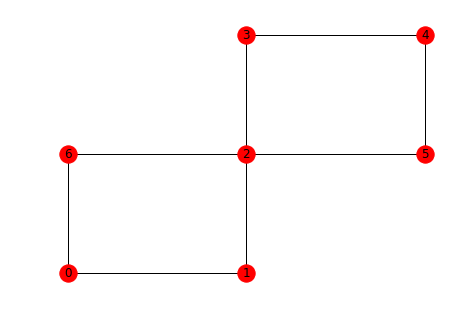

LOG Concorde path [0, 6, 3, 4, 5, 2, 1]
LOG Concorde answer 8


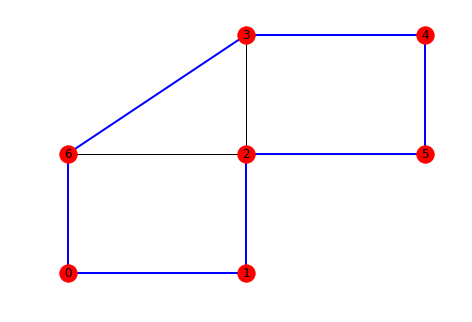

LOG Граф с 7 вершинами и 8 рёбрами
LOG Число комбинаций для перебора 247 при K=8
LOG              GLOBAL ITERATION 1


HBox(children=(IntProgress(value=0, max=247), HTML(value='')))

LOG Changing A: 6 0 1
LOG Changing A: 5 0 0
LOG Changing A: 4 0 0
LOG Changing A: 4 7 0
LOG Changing A: 3 7 1
LOG Changing A: 2 7 0
LOG Changing A: 1 0 0

LOG              GLOBAL ITERATION 2


HBox(children=(IntProgress(value=0, max=247), HTML(value='')))

LOG Early exit: nothing to check

LOG Algorithm answer 8
LOG Algorithm set [(0, 6), (0, 1), (2, 6), (2, 3), (3, 4), (4, 5)]
LOG Algorithm K 2


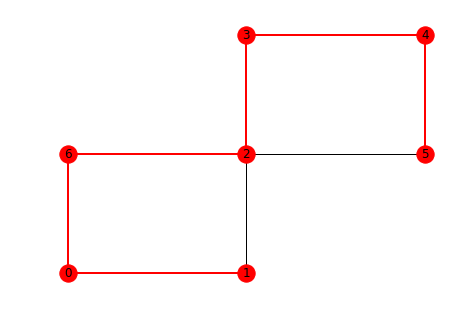

LOG ALGORITHM SUCCEEDED


(True, {'Aans': 8, 'Cans': 8, 'K': 2})

In [8]:
G = get_G(
    [[0, {'pos':(0,0)}],
     [1, {'pos':(1,0)}],
     [2, {'pos':(1,1)}],
     [3, {'pos':(1,2)}],
     [4, {'pos':(2,2)}],
     [5, {'pos':(2,1)}],
     [6, {'pos':(0,1)}]],
    [[2, 6], [6, 0], [0, 1], [1,2], [2, 3], [3, 4], [4, 5], [5, 2]])

# import dot2tex as d2t
# dot_object = nx.drawing.nx_pydot.to_pydot(G)
# texcode = d2t.dot2tex(dot_object.to_string(), format='tikz', crop=True)
process_tsp_manual(G, draw=False, positioned=True, earlystop=False)

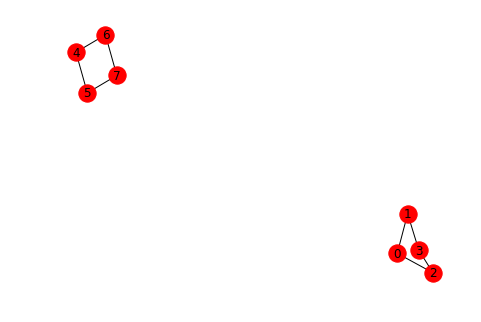

LOG Concorde path [0, 6, 4, 5, 7, 2, 3, 1]
LOG Concorde answer 10


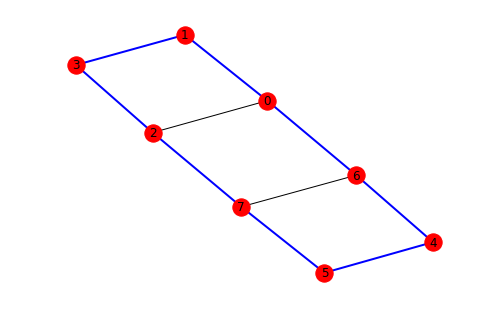

LOG Граф с 8 вершинами и 8 рёбрами
LOG Число комбинаций для перебора 247 при K=8
LOG              GLOBAL ITERATION 1


HBox(children=(IntProgress(value=0, max=247), HTML(value='')))

LOG Changing A: 7 0 1
LOG Changing A: 6 0 0
LOG Changing A: 5 0 0
LOG Changing A: 5 8 0
LOG Changing A: 4 8 1
LOG Changing A: 3 8 0
LOG Changing A: 2 8 0
LOG Changing A: 2 16 0

LOG              GLOBAL ITERATION 2


HBox(children=(IntProgress(value=0, max=247), HTML(value='')))

LOG Early exit: nothing to check

LOG Algorithm answer 10
LOG Algorithm set [(0, 1), (0, 2), (1, 3), (2, 3), (4, 5), (4, 6), (5, 7), (6, 7)]
LOG Algorithm K 1


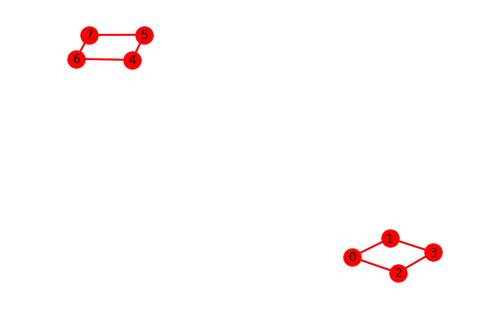

LOG ALGORITHM SUCCEEDED


(True, {'Aans': 10, 'Cans': 10, 'K': 1})

In [9]:
process_tsp_manual(get_G(
    [[0, {'pos':(0,0)}],
     [1, {'pos':(1,0)}],
     [2, {'pos':(0,1)}],
     [3, {'pos':(1,1)}],
     [4, {'pos':(3,0)}],
     [5, {'pos':(4,0)}],
     [6, {'pos':(3,1)}],
     [7, {'pos':(4,1)}]],
    [[0, 1], [1, 3], [3, 2], [2,0], [6, 7], [7, 5], [5, 4], [4, 6]]),
                  draw=False, positioned=False, earlystop=False)


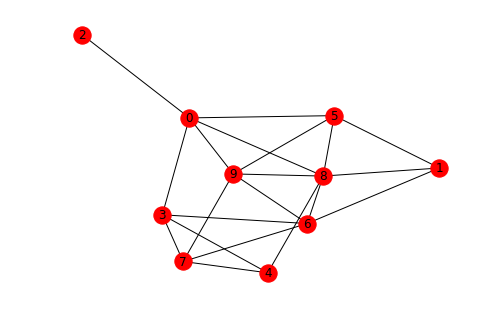

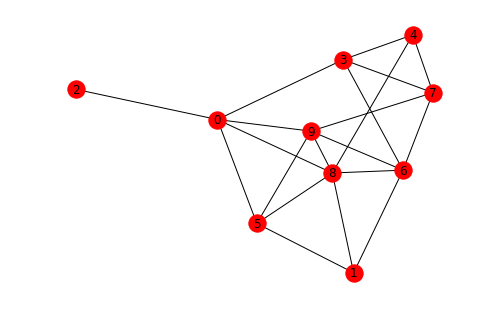

LOG Concorde path [0, 8, 4, 7, 3, 6, 1, 5, 9, 2]
LOG Concorde answer 11


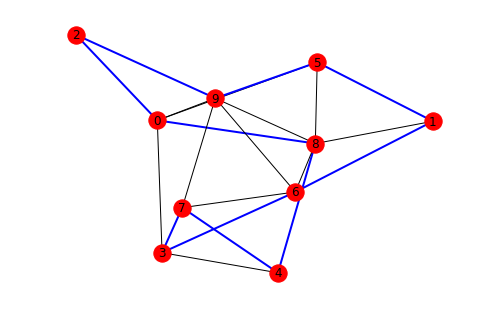

LOG Граф с 10 вершинами и 20 рёбрами
LOG Число комбинаций для перебора 1042359 при K=15
LOG              GLOBAL ITERATION 1


HBox(children=(IntProgress(value=0, max=1042359), HTML(value='')))

LOG Changing A: 9 0 1
LOG Changing A: 8 0 0
LOG Changing A: 7 0 0
LOG Changing A: 6 0 0
LOG Changing A: 5 0 0
LOG Changing A: 4 0 0
LOG Changing A: 3 0 0
LOG Changing A: 2 0 0
LOG K=1 was enough

LOG Algorithm answer 12
LOG Algorithm set [(0, 9), (0, 5), (1, 5), (1, 6), (3, 6), (3, 4), (4, 8), (7, 9)]
LOG Algorithm K 1


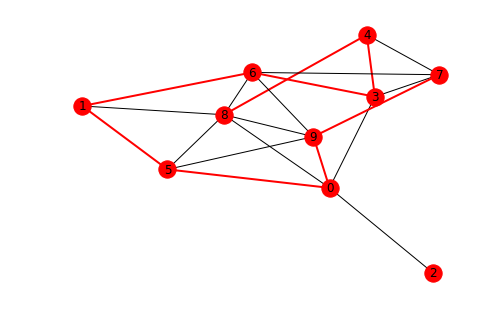

LOG ALGORITHM SUCCEEDED


(True, {'Aans': 12, 'Cans': 11, 'K': 1})

In [11]:
def set_edges_weight(G, w):
    for u, v in G.edges():
        G[u][v]['weight'] = w
    return G

def gen_random_graph(n, p=None, m=None):
    if p is None and m is None or not (p is None or m is None):
        raise Exception("Wrong params")
        
    if p is not None:
        G = nx.random_graphs.gnp_random_graph(n, p)
    else:
        G = nx.random_graphs.gnm_random_graph(n, m)
    if log.getLogger().isEnabledFor(log.INFO):
        nx.draw(G, with_labels=True)
    plt.show()
    G = set_edges_weight(G, 1)
    return G

G = gen_random_graph(10, m=20)
#G = gen_random_graph(20, m=180)
#process_tsp_manual(G)
process_tsp_manual(G, draw=False, earlystop=True)

In [38]:
log.getLogger().setLevel(log.ERROR)
nodes_failures = 0
edges_failures = 0
nodes_Ks = []
edges_Ks = []

N = np.arange(5, 51, 5)
E = np.arange(5, 121, 5)
out = []
pbar = tqdm.tqdm_notebook(total=len(N)*len(E)*10)
for n in N:
    for e in E:
        for i in range(0, 10):
            pbar.update(1)
            G = gen_random_graph(n, m=e)
#             b, d = process_tsp_manual(G)
#             if b == False:
#                 nodes_failures += 1
#             else:
#                 nodes_Ks.append(d['K'])
            b, d = process_tsp_manual(G)
            #if d['K'] >= 3:
            #    print(out[-1])
            if b == False:
                edges_failures += 1
            else:
                out.append((d['K'], n, e))
pbar.close()

HBox(children=(IntProgress(value=0, max=2400), HTML(value='')))

In [103]:
log.getLogger().setLevel(log.INFO)

In [104]:
log.getLogger().isEnabledFor(log.INFO)

True

In [41]:
import pandas as pd
data = pd.DataFrame(out)

[1 1 1]


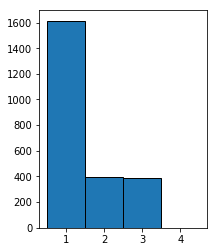

[5 5 5 5 5 5 5 5 5]


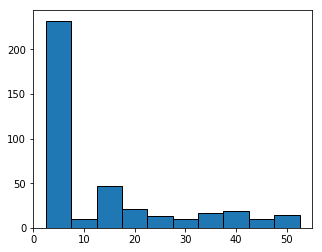

[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]


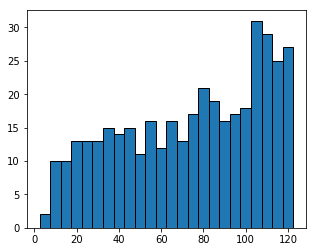

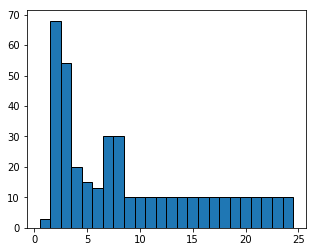

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]))
0 0


In [95]:

dat = data[0]
def plt_hist(dat, d=None):
    if d is None:
        d = np.diff(np.unique(dat)).min()
        print(np.diff(np.unique(dat)))

    left_of_first_bin = dat.min() - float(d)/2
    right_of_last_bin = dat.max() + float(d)/2
    plt.hist(dat, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black')
    
plt.figure(figsize=(3, 4))
plt_hist(data[0])
plt.show()
plt.figure(figsize=(5, 4))
plt_hist(data[data[0]>=3][1])
plt.show()
plt.figure(figsize=(5, 4))
plt_hist(data[data[0]>=3][2])
plt.show()
plt.figure(figsize=(5, 4))
plt_hist(data[data[0]>=3][2]/data[data[0]>=3][1], d=1)
plt.show()
print(np.histogram(edges_Ks))
print(nodes_failures, edges_failures)